<a href="https://colab.research.google.com/github/demelere/Text-Classification/blob/master/458_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A. Setup

In [ ]:
import numpy as np
import pandas as pd
import os
from collections import Counter
import datetime
import copy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import reuters
from tensorflow.keras import preprocessing
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, SimpleRNN, LSTM, Conv1D, MaxPooling1D

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
keras.__version__

'2.2.4-tf'

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## B. Data import

In [ ]:
# Restrict data to the 10000 most frequent words in the data
voc_size = 10000

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=voc_size)

In [ ]:
len(train_data), len(train_labels), len(test_data), len(test_labels)

(8982, 8982, 2246, 2246)

In [ ]:
print(train_data[1]) 

[1, 3267, 699, 3434, 2295, 56, 2, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 2, 49, 2295, 2, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 2, 2, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12]


In [ ]:
max([len(set(lst)) for lst in train_data])

530

In [ ]:
# Use the reuters.get_word_index method to return a dictionary to translate indices to words
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[1]])
decoded_newswire

'? generale de banque sa lt ? br and lt heller overseas corp of chicago have each taken 50 pct stakes in ? company sa ? factors generale de banque said in a statement it gave no financial details of the transaction sa ? ? turnover in 1986 was 17 5 billion belgian francs reuter 3'

In [ ]:
# Number of words in the document
len(decoded_newswire.split()) 

56

In [ ]:
# First 7 words in the document
decoded_newswire.split()[:7]

['?', 'generale', 'de', 'banque', 'sa', 'lt', '?']

In [ ]:
# The list of encodings is the same size as the number of words in the document
len(train_data[1])

56

In [ ]:
train_data[1][:7] # The encodings of the first 7 words in the document. Again, 2 = "unknown"

[1, 3267, 699, 3434, 2295, 56, 2]

In [ ]:
len(Counter(list(train_labels)).keys()) # There are 46 topics

46

In [ ]:
# The ten most common train labels
from collections import Counter
train_label_tuples = \
Counter(list(train_labels)).most_common(10) # if we keep the top nine we get the same training and test labels
train_label_tuples

[(3, 3159),
 (4, 1949),
 (19, 549),
 (16, 444),
 (1, 432),
 (11, 390),
 (20, 269),
 (13, 172),
 (8, 139),
 (10, 124)]

In [ ]:
# The ten most common test labels
from collections import Counter
test_label_tuples = \
Counter(list(test_labels)).most_common(10) # if we keep the top 9 we get the same training and test labels
test_label_tuples

[(3, 813),
 (4, 474),
 (19, 133),
 (1, 105),
 (16, 99),
 (11, 83),
 (20, 70),
 (8, 38),
 (13, 37),
 (25, 31)]

In [ ]:


# Separate the the labels from their frequencies
topics_train_tpl, train_freq = zip(*Counter(list(train_labels)).most_common(9))
topics_train_tpl

(3, 4, 19, 16, 1, 11, 20, 13, 8)

In [ ]:
train_freq

(3159, 1949, 549, 444, 432, 390, 269, 172, 139)

In [ ]:
topics_test_tpl, test_freq = zip(*Counter(list(test_labels)).most_common(9))
topics_test_tpl

(3, 4, 19, 1, 16, 11, 20, 8, 13)

In [ ]:
sum(test_freq) # number of test values in top 10

1852

In [ ]:
sum(train_freq)  # number of training values in top 10

7503

In [ ]:
train_data_sm, train_labels_sm = zip(*((x,y) for x,y in zip(train_data,train_labels) if y in topics_train_tpl))

In [ ]:
train_data_sm, train_labels_sm = np.array(train_data_sm), np.array(train_labels_sm)

In [ ]:
len(train_data_sm), len(train_labels_sm)  # matches number of training values in top 10

(7503, 7503)

In [ ]:
test_data_sm, test_labels_sm = zip(*((x,y) for x,y in zip(test_data,test_labels) if y in topics_test_tpl))

In [ ]:
test_data_sm, test_labels_sm = np.array(test_data_sm), np.array(test_labels_sm)

In [ ]:
len(test_data_sm), len(test_labels_sm) # matches number of test values in top 10

(1852, 1852)

In [ ]:
Counter(train_labels_sm)

Counter({3: 3159,
         4: 1949,
         16: 444,
         19: 549,
         8: 139,
         11: 390,
         1: 432,
         13: 172,
         20: 269})

In [ ]:
Counter(test_labels_sm)

Counter({3: 813,
         1: 105,
         4: 474,
         11: 83,
         19: 133,
         8: 38,
         20: 70,
         16: 99,
         13: 37})

In [ ]:
# first define relabeling function
keys = Counter(test_labels_sm).keys()
conv = dict(zip(sorted(keys),range(0,9)))
conv

{1: 0, 3: 1, 4: 2, 8: 3, 11: 4, 13: 5, 16: 6, 19: 7, 20: 8}

In [ ]:
# next create the new labels
train_labels_sm2 = [conv[l] for l in train_labels_sm]
test_labels_sm2 = [conv[l] for l in test_labels_sm]
print(Counter(train_labels_sm2))  # Looks like they were relabeled correctly
print(Counter(test_labels_sm2))   # Looks like they were relabeled correctly

Counter({1: 3159, 2: 1949, 7: 549, 6: 444, 0: 432, 4: 390, 8: 269, 5: 172, 3: 139})
Counter({1: 813, 2: 474, 7: 133, 0: 105, 6: 99, 4: 83, 8: 70, 3: 38, 5: 37})


In [ ]:
# https://www.kaggle.com/maximarufo/nlp-classification-reuters-dataset
class_to_idx =  \
{'copper': 6, 'livestock': 28, 'gold': 25, 
 'money-fx': 19, 'ipi': 30, 'trade': 11, 
 'cocoa': 0, 'iron-steel': 31, 'reserves': 12, 
 'tin': 26, 'zinc': 37, 'jobs': 34, 'ship': 13, 
 'cotton': 14, 'alum': 23, 'strategic-metal': 27, 
 'lead': 45, 'housing': 7, 'meal-feed': 22, 'gnp': 21, 
 'sugar': 10, 'rubber': 32, 'dlr': 40, 'veg-oil': 2, 
 'interest': 20, 'crude': 16, 'coffee': 9, 'wheat': 5, 
 'carcass': 15, 'lei': 35, 'gas': 41, 'nat-gas': 17, 
 'oilseed': 24, 'orange': 38, 'heat': 33, 'wpi': 43, 
 'silver': 42, 'cpi': 18, 'earn': 3, 'bop': 36, 'money-supply': 8, 
 'hog': 44, 'acq': 4, 'pet-chem': 39, 'grain': 1, 'retail': 29}

In [ ]:
idx_to_class = dict([(value, key) for (key, value) in class_to_idx.items()])
{k: idx_to_class[k] for k in list(idx_to_class)[:15]} # get 15 key value pairs

{6: 'copper',
 28: 'livestock',
 25: 'gold',
 19: 'money-fx',
 30: 'ipi',
 11: 'trade',
 0: 'cocoa',
 31: 'iron-steel',
 12: 'reserves',
 26: 'tin',
 37: 'zinc',
 34: 'jobs',
 13: 'ship',
 14: 'cotton',
 23: 'alum'}

In [ ]:
# get the dictionary for our smaller data set
idx_to_class_sm = {k:v for k,v in idx_to_class.items() if k in topics_test_tpl}
idx_to_class_sm 

{19: 'money-fx',
 11: 'trade',
 13: 'ship',
 20: 'interest',
 16: 'crude',
 3: 'earn',
 8: 'money-supply',
 4: 'acq',
 1: 'grain'}

In [ ]:
# Explore a selection of records from the smaller set
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data_sm[16]])
decoded_newswire

'? standard oil co said a contract has been awarded to lt cbs engineering inc for a drilling and production platform to be installed in ? bank block 826 in the gulf of mexico where standard and mobil corp each own a 40 pct interest standard said its standard oil production co subsidiary will operate the platform which is being designed to produce 15 000 barrels of oil and 50 mln cubic feet of gas daily the platform is now expected to be installed in the summer of 1988 other owners are ? ? corp lt ? with 16 66 pct and lt prudential insurance co of america with 3 34 pct reuter 3'

In [ ]:
idx_to_class_sm[train_labels_sm[16]]   # checking the dictionary...topic seems to be right

'crude'

In [ ]:
train_data_sm.shape, test_data_sm.shape, train_data.shape, test_data.shape

((7503,), (1852,), (8982,), (2246,))

In [ ]:
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/3.6-classifying-newswires.ipynb
def vectorize_sequences(sequences, dimension=voc_size):   # one row per one column per word in the vocabulary
    results = np.zeros((len(sequences), dimension))
    
    # Say the the ith sequence = [12, 15, 12, 1], then results[i,squence] = 1 is equivalent to
    # results[12] = 1 (executed twice)
    # results[15] = 1
    # results]1] = 1
    # Consequently, the ith row will consist of 1s in columns 1, 12 and 15, and 0s everywhere else
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data for both the original and smaller datasets
train_data_smv = vectorize_sequences(train_data_sm)
train_data_v = vectorize_sequences(train_data)
# Our vectorized test data for both the original and smaller datasets
test_data_smv = vectorize_sequences(test_data_sm)
test_data_v = vectorize_sequences(test_data)

In [ ]:
train_data_sm.shape, train_data_smv.shape, test_data_sm.shape, test_data_smv.shape

((7503,), (7503, 10000), (1852,), (1852, 10000))

In [ ]:
# Summary of the shapes of the training and test data before and after vectorization
train_data.shape, train_data_v.shape, test_data_v.shape, test_data_v.shape

((8982,), (8982, 10000), (2246, 10000), (2246, 10000))

In [ ]:
# [1,0,0,0,0,1,0]

In [ ]:
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
one_hot_train_labels_sm = to_categorical(train_labels_sm2)
one_hot_test_labels_sm = to_categorical(test_labels_sm2)
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [ ]:
# Shape of the training and test labels after (categorical) vectorization
one_hot_train_labels_sm.shape, one_hot_test_labels_sm.shape

((7503, 9), (1852, 9))

In [ ]:
# Define callback to get total training time
class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [ ]:
# Define callback to get total test time
class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

# 1. Experiment 1: DNN

## 1.1 DNN w/64 and 32 nodes



In [ ]:
# To test the effect of reducing the number of topics from 46 to (effectively) 9.

# This is the model to be used with data from all 46 topics
model_1_full = Sequential()
model_1_full.add(Dense(units = 64, activation='relu', input_shape=(voc_size,))) # vocabulary size = 10,000
model_1_full.add(Dense(units = 32, activation='relu'))
model_1_full.add(Dense(units = 46, activation='softmax'))

# This is the model we will use with data from the top 9 topics.
model_1 = Sequential()
model_1.add(Dense(units = 64, activation='relu', input_shape=(voc_size,))) # vocabulary size = 10,000
model_1.add(Dense(units = 32, activation='relu'))
model_1.add(Dense(units = 9, activation='softmax'))

In [ ]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 297       
Total params: 642,441
Trainable params: 642,441
Non-trainable params: 0
_________________________________________________________________


Architecture notes:

* We are ending the network with a `Dense` layer of size 46 (for the full model) or 9 (for the model with reduced topics). This means that for each input sample, our network will output a 46- or 9-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
* The last layer uses a `softmax` activation. You have already seen this pattern in the MNIST example. It means that the network will output a _probability distribution_ over the 46 or 9 different output classes, i.e. for every input sample, the network will produce a 9-dimensional output vector where `output[i]` is the probability that the sample belongs to class `i`. The 46 or 9 scores will sum to 1.

The best loss function to use in this case is `categorical_crossentropy`. It measures the distance between two probability distributions: 
in our case, between the probability distribution output by our network, and the true distribution of the labels. By minimizing the 
distance between these two distributions, we train our network to output something as close as possible to the true labels.

In [ ]:
# Compile both models
model_1_full.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 1.1.a Model Training

Train both networks for 10 epochs (but without callbacks on the full datasets model):

In [ ]:
# Train full datasets model with all 46 topics
history_full = model_1_full.fit(train_data_v,
                    one_hot_train_labels,
                    epochs=10,
                    batch_size=100,
                    validation_split = 0.15)   

Train on 7634 samples, validate on 1348 samples
Epoch 1/10
7634/7634 [==============================] - 3s 369us/sample - loss: 2.2494 - accuracy: 0.5431 - val_loss: 1.3863 - val_accuracy: 0.7003
Epoch 2/10
7634/7634 [==============================] - 2s 203us/sample - loss: 1.0415 - accuracy: 0.7697 - val_loss: 1.0877 - val_accuracy: 0.7611
Epoch 3/10
7634/7634 [==============================] - 2s 203us/sample - loss: 0.6544 - accuracy: 0.8600 - val_loss: 0.9843 - val_accuracy: 0.7856
Epoch 4/10
7634/7634 [==============================] - 2s 204us/sample - loss: 0.4191 - accuracy: 0.9126 - val_loss: 0.9593 - val_accuracy: 0.7938
Epoch 5/10
7634/7634 [==============================] - 2s 205us/sample - loss: 0.2928 - accuracy: 0.9392 - val_loss: 0.9765 - val_accuracy: 0.7975
Epoch 6/10
7634/7634 [==============================] - 2s 208us/sample - loss: 0.2219 - accuracy: 0.9489 - val_loss: 1.0049 - val_accuracy: 0.7945
Epoch 7/10
7634/7634 [==============================] - 2s 218us

In [ ]:
print(f"train_acc: {history_full.history['accuracy'][-1]}, val_acc: {history_full.history['val_accuracy'][-1]}")

train_acc: 0.9576892852783203, val_acc: 0.7922848463058472


In [ ]:
train_rt = TrainRuntimeCallback()
history = model_1.fit(train_data_smv,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
#                     validation_data=(val_data_smv, one_hot_val_labels_sm))
                    validation_split = 0.15)   # comment out if setting validation_data value.

# Save models locally after fitting
save_dir = "results/"
model_name = 'Reuters_1.h5'
model_path = os.path.join(save_dir, model_name)
model_1.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 2s 366us/sample - loss: 1.1775 - accuracy: 0.6956 - val_loss: 0.6235 - val_accuracy: 0.8561
Epoch 2/10
6377/6377 [==============================] - 2s 243us/sample - loss: 0.4249 - accuracy: 0.9087 - val_loss: 0.5214 - val_accuracy: 0.8730
Epoch 3/10
6377/6377 [==============================] - 2s 242us/sample - loss: 0.2465 - accuracy: 0.9461 - val_loss: 0.5142 - val_accuracy: 0.8774
Epoch 4/10
6377/6377 [==============================] - 1s 200us/sample - loss: 0.1719 - accuracy: 0.9597 - val_loss: 0.5394 - val_accuracy: 0.8766
Epoch 5/10
6377/6377 [==============================] - 1s 206us/sample - loss: 0.1338 - accuracy: 0.9653 - val_loss: 0.5730 - val_accuracy: 0.8686
Epoch 6/10
6377/6377 [==============================] - 1s 205us/sample - loss: 0.1194 - accuracy: 0.9652 - val_loss: 0.5870 - val_accuracy: 0.8712
Epoch 7/10
6377/6377 [==============================] - 1s 202us

In [ ]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

14.734655

In [ ]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.9655010104179382, val_acc: 0.8632326722145081


This is a significant improvement in performance seen with reduced topics.

### 1.1.b Model Testing

We test both models and get the runtime of the model classifying 9 topics using callbacks. Again, the model with less classes has better performance.

In [ ]:
# Note the original model evaluating the data with 46 topics performs worse on the test data
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_1_full.evaluate(test_data_v, one_hot_test_labels, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.7853962779045105, test_loss=1.0987346781648277


In [ ]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_1.evaluate(test_data_smv, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.8601511716842651, test_loss=0.678581937600418


In [ ]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.241027

### 1.1.c Model Results

In [ ]:
# Use history to collect statistics
history_dict = history.history
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
# # DataFrame for model with 9 topics
history_df=pd.DataFrame(history_dict)
# history_df['test_accuracy'] = test_accuracy
# history_df = history_df.iloc[-1:]
history_df

,loss,accuracy,val_loss,val_accuracy
0,1.177451,0.695625,0.623516,0.856128
1,0.424921,0.908735,0.521417,0.873002
2,0.246452,0.946056,0.514237,0.877442
3,0.171886,0.959699,0.539383,0.876554
4,0.133797,0.965344,0.572965,0.868561
5,0.119446,0.965187,0.586977,0.871226
6,0.104785,0.967226,0.623641,0.863233
7,0.105915,0.966442,0.633889,0.867673
8,0.092627,0.968637,0.633280,0.865009
9,0.094744,0.965501,0.683556,0.863233


In [ ]:
# Create a results DataFrame using the last row of history_df
results_df = history_df.iloc[-1:].copy()
results_df.insert(0,'model','DNN (2 layers) 9 topics') # want the model name to appear first
results_df['test_accuracy'] = test_accuracy
results_df['test_loss'] = test_loss
results_df['training time (sec)'] = train_time     
results_df['testing time (sec)'] = test_time    
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,DNN (2 layers) 9 topics,0.094744,0.965501,0.683556,0.863233,0.860151,0.678582,14.734655,0.241027


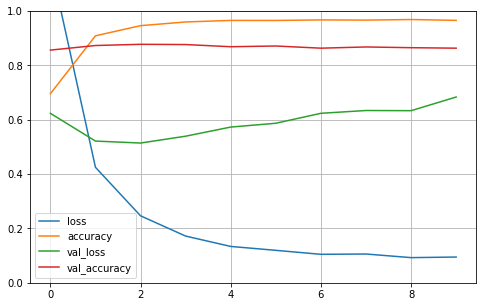

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_1", tight_layout=False)
plt.show()

## 1.2. DNN w/256 and 256 nodes

In [ ]:
# This is the model we will use with data from the top 9 topics.
model_1a = Sequential()
model_1a.add(Dense(units =  256, activation='relu', input_shape=(voc_size,))) # vocabulary size = 10,000
model_1a.add(Dense(units =  256, activation='relu'))
model_1a.add(Dense(units =  9, activation='softmax'))

In [ ]:
model_1a.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               2560256   
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 2313      
Total params: 2,628,361
Trainable params: 2,628,361
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1a.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
train_rt = TrainRuntimeCallback()
history = model_1a.fit(train_data_smv,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
#                     validation_data=(val_data_smv, one_hot_val_labels_sm))
                    validation_split = 0.15)   # comment out if setting validation_data value.

# Saving models locally after fitting
save_dir = "results/"
model_name = 'Reuters_1a.h5'
model_path = os.path.join(save_dir, model_name)
model_1a.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 4s 696us/sample - loss: 0.8306 - accuracy: 0.7784 - val_loss: 0.5197 - val_accuracy: 0.8801
Epoch 2/10
6377/6377 [==============================] - 4s 583us/sample - loss: 0.2712 - accuracy: 0.9360 - val_loss: 0.5245 - val_accuracy: 0.8801
Epoch 3/10
6377/6377 [==============================] - 4s 594us/sample - loss: 0.1572 - accuracy: 0.9611 - val_loss: 0.5580 - val_accuracy: 0.8703
Epoch 4/10
6377/6377 [==============================] - 4s 566us/sample - loss: 0.1192 - accuracy: 0.9650 - val_loss: 0.5871 - val_accuracy: 0.8668
Epoch 5/10
6377/6377 [==============================] - 4s 556us/sample - loss: 0.1021 - accuracy: 0.9653 - val_loss: 0.6120 - val_accuracy: 0.8588
Epoch 6/10
6377/6377 [==============================] - 4s 582us/sample - loss: 0.0900 - accuracy: 0.9658 - val_loss: 0.6361 - val_accuracy: 0.8579
Epoch 7/10
6377/6377 [==============================] - 5s 707us

In [ ]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

39.019436

In [ ]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.9678532481193542, val_acc: 0.865896999835968


### 1.2.a Model Testing

In [ ]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_1a.evaluate(test_data_smv, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.8590712547302246, test_loss=0.7554670130717317


In [ ]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.288834

### 1.2.b Model Performance

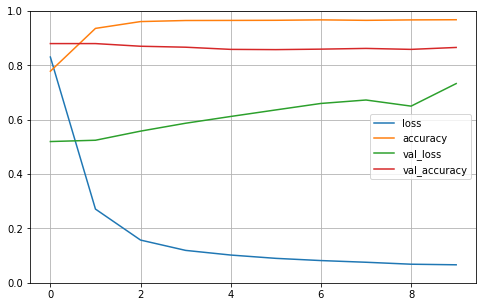

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_1a", tight_layout=False)
plt.show()

In [ ]:
# Use history to collect statistics
history_dict = history.history
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
# # DataFrame for model with 9 topics
history_df=pd.DataFrame(history_dict)
# history_df['test_accuracy'] = test_accuracy
# history_df = history_df.iloc[-1:]
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.830591,0.778422,0.519692,0.880107
1,0.271225,0.936020,0.524478,0.880107
2,0.157211,0.961110,0.558012,0.870337
3,0.119244,0.965031,0.587073,0.866785
4,0.102112,0.965344,0.611959,0.858792
5,0.089959,0.965815,0.636065,0.857904
6,0.081804,0.967383,0.659852,0.859680
7,0.075589,0.965658,0.672524,0.862345
8,0.068394,0.967226,0.650002,0.858792
9,0.066245,0.967853,0.732996,0.865897


In [ ]:
# Create a results DataFrame using the last row of history_df
results_df1a = history_df.iloc[-1:].copy()
results_df1a.insert(0,'model','DNN (2 layers 256/256)') # went the model name to appear first
results_df1a['test_accuracy'] = test_accuracy
results_df1a['test_loss'] = test_loss
results_df1a['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df1a['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df1a

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,DNN (2 layers 256/256),0.066245,0.967853,0.732996,0.865897,0.859071,0.755467,39.019436,0.288834


## 1.3 Baseline Model

In [ ]:
test_labels_sm_copy = copy.copy(test_labels_sm)
np.random.shuffle(test_labels_sm_copy)
float(np.sum(np.array(test_labels_sm) == np.array(test_labels_sm_copy))) / len(test_labels_sm)
# test_labels_copy = copy.copy(test_labels)
# np.random.shuffle(test_labels_copy)
# float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.26187904967602593

## 1.3 Baseline Model w/10% dropout

In [ ]:
model_1do = Sequential()
model_1do.add(Dense(units =64, activation='relu', input_shape=(voc_size,))) # vocabulary size = 10,000
model_1do.add(layers.Dropout(0.1))
model_1do.add(Dense(units =32, activation='relu'))
model_1do.add(layers.Dropout(0.1))
model_1do.add(Dense(units =9, activation='softmax'))

model_1do.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                640064    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 9)                 297       
Total params: 642,441
Trainable params: 642,441
Non-trainable params: 0
_________________________________________________________________


### 1.3.a Model Training

In [ ]:
model_1do.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
train_rt = TrainRuntimeCallback()
history = model_1do.fit(train_data_smv,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
                    validation_split = 0.15)  

# Saving models locally after fitting
save_dir = "results/"
model_name = 'Reuters_1do.h5'
model_path = os.path.join(save_dir, model_name)
model_1do.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 2s 379us/sample - loss: 1.1504 - accuracy: 0.6894 - val_loss: 0.6204 - val_accuracy: 0.8428
Epoch 2/10
6377/6377 [==============================] - 1s 218us/sample - loss: 0.4784 - accuracy: 0.8874 - val_loss: 0.5089 - val_accuracy: 0.8730
Epoch 3/10
6377/6377 [==============================] - 1s 214us/sample - loss: 0.3054 - accuracy: 0.9323 - val_loss: 0.5075 - val_accuracy: 0.8801
Epoch 4/10
6377/6377 [==============================] - 1s 217us/sample - loss: 0.2177 - accuracy: 0.9484 - val_loss: 0.5252 - val_accuracy: 0.8810
Epoch 5/10
6377/6377 [==============================] - 1s 227us/sample - loss: 0.1667 - accuracy: 0.9573 - val_loss: 0.5476 - val_accuracy: 0.8757
Epoch 6/10
6377/6377 [==============================] - 1s 223us/sample - loss: 0.1366 - accuracy: 0.9631 - val_loss: 0.5835 - val_accuracy: 0.8677
Epoch 7/10
6377/6377 [==============================] - 2s 296us

In [ ]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

15.595836

### 1.3.b Model Testing

In [ ]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_1do.evaluate(test_data_smv, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0) 
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.8574513792991638, test_loss=0.7035018586700472


In [ ]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.186922

### 1.3.c Model Performance

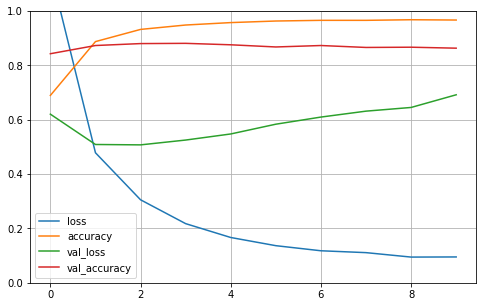

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_1do", tight_layout=False)
plt.show()

In [ ]:
history_dict = history.history
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [ ]:
results_df1do = history_df.iloc[-1:].copy()
results_df1do.insert(0,'model','DNN (2 layers) w Drop') # want the model name to appear first
results_df1do['test_accuracy'] = test_accuracy
results_df1do['test_loss'] = test_loss
results_df1do['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df1do['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df1do

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,DNN (2 layers) w Drop,0.095098,0.966756,0.69174,0.863233,0.857451,0.703502,15.595836,0.186922


## 1.4: Baseline Model w/10% dropout and L1 regularization

In [ ]:
model_1reg = Sequential()
model_1reg.add(Dense(units=64, kernel_regularizer=regularizers.l1(0.001), activation='relu', input_shape=(voc_size,))) # vocabulary size = 10,000
model_1reg.add(layers.Dropout(0.1))
model_1reg.add(Dense(units=32, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model_1reg.add(layers.Dropout(0.1))
model_1reg.add(Dense(units=9, activation='softmax'))

model_1reg.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 9)                 297       
Total params: 642,441
Trainable params: 642,441
Non-trainable params: 0
_________________________________________________________________


### 1.4.a Model Training

In [ ]:
model_1reg.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
train_rt = TrainRuntimeCallback()
history = model_1reg.fit(train_data_smv,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
                    validation_split = 0.15) 

# Saving models locally after fitting
save_dir = "results/"
model_name = 'Reuters_1reg.h5'
model_path = os.path.join(save_dir, model_name)
model_1reg.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 3s 477us/sample - loss: 3.2436 - accuracy: 0.6293 - val_loss: 1.4733 - val_accuracy: 0.8037
Epoch 2/10
6377/6377 [==============================] - 2s 361us/sample - loss: 1.3500 - accuracy: 0.8103 - val_loss: 1.2425 - val_accuracy: 0.8375
Epoch 3/10
6377/6377 [==============================] - 2s 310us/sample - loss: 1.2080 - accuracy: 0.8386 - val_loss: 1.1620 - val_accuracy: 0.8446
Epoch 4/10
6377/6377 [==============================] - 2s 315us/sample - loss: 1.1347 - accuracy: 0.8474 - val_loss: 1.1294 - val_accuracy: 0.8552
Epoch 5/10
6377/6377 [==============================] - 2s 313us/sample - loss: 1.1040 - accuracy: 0.8551 - val_loss: 1.0983 - val_accuracy: 0.8579
Epoch 6/10
6377/6377 [==============================] - 2s 304us/sample - loss: 1.0709 - accuracy: 0.8653 - val_loss: 1.0930 - val_accuracy: 0.8659
Epoch 7/10
6377/6377 [==============================] - 2s 301us

In [ ]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

21.216728

### 1.4.b Model Testing

In [ ]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_1reg.evaluate(test_data_smv, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0) 
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.854211688041687, test_loss=1.0845474715366734


In [ ]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.246425

### 1.4.c Model Performance

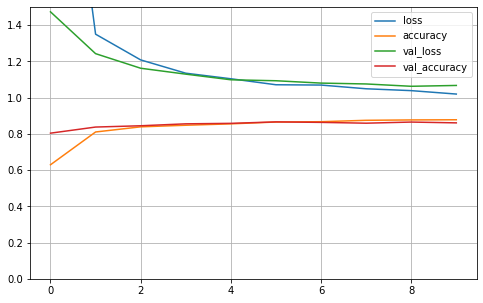

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_1reg", tight_layout=False)
plt.show()

In [ ]:
history_dict = history.history
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [ ]:
results_df1reg = history_df.iloc[-1:].copy()
results_df1reg.insert(0,'model','DNN (2 layers) w Drop and L1') # want the model name to appear first
results_df1reg['test_accuracy'] = test_accuracy
results_df1reg['test_loss'] = test_loss
results_df1reg['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df1reg['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df1reg

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,DNN (2 layers) w Drop and L1,1.019556,0.877685,1.067072,0.860568,0.854212,1.084547,21.216728,0.246425


## 1.5 Baseline Model w/embedding layer

In [ ]:
train_data_smv.shape

(7503, 10000)

In [ ]:
train_data_sm_len =[len(w) for w in train_data_sm]
maxlen = int(np.percentile(train_data_sm_len, 80))
f"80th percentile of train_data_sm : {maxlen}"

'80th percentile of train_data_sm : 193'

In [ ]:
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb
train_data_smv = preprocessing.sequence.pad_sequences(train_data_sm, maxlen=maxlen)
test_data_smv = preprocessing.sequence.pad_sequences(test_data_sm, maxlen=maxlen)

In [ ]:
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb
model_1emb = Sequential()

# We specify the maximum input length to our Embedding layer so we can later flatten the embedded inputs
model_1emb.add(Embedding(voc_size, 128, input_length = maxlen))  # vocabulary size = 10,000
# After the Embedding layer, our activations have shape `(samples, maxlen, 30)`.

# We flatten the 3D tensor of embeddings into a 2D tensor of shape `(samples, maxlen * 30)`
model_1emb.add(Flatten())
model_1emb.add(Dense(units = 64, activation='relu'))
model_1emb.add(Dense(units = 32, activation='relu'))

# We add the classifier on top
model_1emb.add(Dense(units = 9, activation='softmax'))
model_1emb.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 193, 128)          1280000   
_________________________________________________________________
flatten (Flatten)            (None, 24704)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                1581120   
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 9)                 297       
Total params: 2,863,497
Trainable params: 2,863,497
Non-trainable params: 0
_________________________________________________________________


### 1.5.a Model Training

In [ ]:
model_1emb.compile(optimizer='adam', 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])

In [ ]:
train_rt = TrainRuntimeCallback()
history = model_1emb.fit(train_data_smv,             
                    one_hot_train_labels_sm,  
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
                    validation_split = 0.15)

# Saving models locally after fitting
save_dir = "results/"
model_name = 'Reuters_1emb.h5'
model_path = os.path.join(save_dir, model_name)
model_1emb.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 6s 984us/sample - loss: 1.3187 - accuracy: 0.5600 - val_loss: 0.9685 - val_accuracy: 0.6794
Epoch 2/10
6377/6377 [==============================] - 6s 901us/sample - loss: 0.6680 - accuracy: 0.8037 - val_loss: 0.7398 - val_accuracy: 0.7798
Epoch 3/10
6377/6377 [==============================] - 5s 859us/sample - loss: 0.2760 - accuracy: 0.9387 - val_loss: 0.7736 - val_accuracy: 0.7957
Epoch 4/10
6377/6377 [==============================] - 6s 866us/sample - loss: 0.1519 - accuracy: 0.9653 - val_loss: 0.7083 - val_accuracy: 0.8162
Epoch 5/10
6377/6377 [==============================] - 5s 831us/sample - loss: 0.1124 - accuracy: 0.9679 - val_loss: 0.7649 - val_accuracy: 0.8135
Epoch 6/10
6377/6377 [==============================] - 5s 850us/sample - loss: 0.0961 - accuracy: 0.9655 - val_loss: 0.7529 - val_accuracy: 0.8144
Epoch 7/10
6377/6377 [==============================] - 6s 880us

In [ ]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

56.138766

### 1.5.b Model Testing

In [ ]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_1emb.evaluate(test_data_smv, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.8115550875663757, test_loss=0.8254771371639573


In [ ]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.217395

### 1.5.c Model Performance

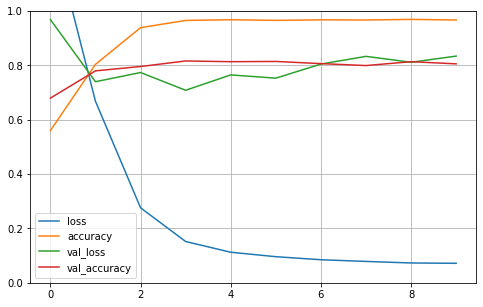

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_1b", tight_layout=False)
plt.show()

In [ ]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [ ]:
results_dfemb = history_df.iloc[-1:].copy()
results_dfemb.insert(0,'model','DNN (2 layers) w Embed') # want the model name to appear first
results_dfemb['test_accuracy'] = test_accuracy
results_dfemb['test_loss'] = test_loss
results_dfemb['training time (sec)'] = train_time
results_dfemb['testing time (sec)'] = test_time     
results_dfemb


,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,DNN (2 layers) w Embed,0.07171,0.966912,0.834077,0.805506,0.811555,0.825477,56.138766,0.217395


### 1.6: Baseline Model w/embedding and 10% dropout

In [ ]:
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb
# from tensorflow.keras.layers import Flatten, Embedding

model_1embdo = Sequential()
model_1embdo.add(Embedding(voc_size, 128, input_length = maxlen))  # vocabulary size = 10,000
model_1embdo.add(Flatten())

model_1embdo.add(Dense(units=64, activation='relu'))
model_1embdo.add(layers.Dropout(0.1))
model_1embdo.add(Dense(units=32, activation='relu'))
model_1embdo.add(layers.Dropout(0.1))
model_1embdo.add(Dense(units=9, activation='softmax'))
model_1embdo.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 193, 128)          1280000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 24704)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                1581120   
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 9)                

### 1.7.a Model Training

In [ ]:
model_1embdo.compile(optimizer='adam', 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])

In [ ]:
train_rt = TrainRuntimeCallback()
history = model_1embdo.fit(train_data_smv,             
                    one_hot_train_labels_sm,  
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
                    validation_split = 0.15)

# Saving models locally after fitting
save_dir = "results/"
model_name = 'Reuters_1embdo.h5'
model_path = os.path.join(save_dir, model_name)
model_1embdo.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 6s 1ms/sample - loss: 1.3447 - accuracy: 0.5600 - val_loss: 0.9665 - val_accuracy: 0.6705
Epoch 2/10
6377/6377 [==============================] - 5s 815us/sample - loss: 0.7424 - accuracy: 0.7743 - val_loss: 0.7346 - val_accuracy: 0.7895
Epoch 3/10
6377/6377 [==============================] - 6s 883us/sample - loss: 0.3592 - accuracy: 0.9084 - val_loss: 0.6678 - val_accuracy: 0.8188
Epoch 4/10
6377/6377 [==============================] - 5s 823us/sample - loss: 0.1960 - accuracy: 0.9564 - val_loss: 0.6865 - val_accuracy: 0.8242
Epoch 5/10
6377/6377 [==============================] - 6s 913us/sample - loss: 0.1404 - accuracy: 0.9652 - val_loss: 0.7498 - val_accuracy: 0.8259
Epoch 6/10
6377/6377 [==============================] - 6s 920us/sample - loss: 0.1196 - accuracy: 0.9657 - val_loss: 0.7741 - val_accuracy: 0.8206
Epoch 7/10
6377/6377 [==============================] - 6s 881us/s

In [ ]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

55.968919

### 1.7.b Model Testing

In [ ]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_1embdo.evaluate(test_data_smv, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.8191144466400146, test_loss=0.8549322461463977


In [ ]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.217657

### 1.7.c Model Performance

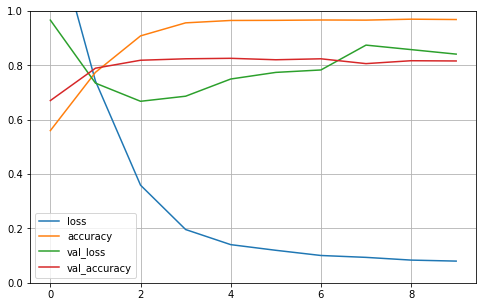

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_1_c", tight_layout=False)
plt.show()

In [ ]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [ ]:
results_dfembdo = history_df.iloc[-1:].copy()
results_dfembdo.insert(0,'model','DNN (2 layers) w Embed + Dropout') # want the model name to appear first
results_dfembdo['test_accuracy'] = test_accuracy
results_dfembdo['test_loss'] = test_loss
results_dfembdo['training time (sec)'] = train_time      
results_dfembdo['testing time (sec)'] = test_time     
results_dfembdo

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,DNN (2 layers) w Embed + Dropout,0.079839,0.968637,0.841354,0.816163,0.819114,0.854932,55.968919,0.217657


In [ ]:
results_df=results_df.append(results_df1a,ignore_index=True)
results_df=results_df.append(results_df1do,ignore_index=True)
results_df=results_df.append(results_df1reg,ignore_index=True)
results_df=results_df.append(results_dfemb,ignore_index=True)
results_df=results_df.append(results_dfembdo,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
0,DNN (2 layers) 9 topics,0.094744,0.965501,0.683556,0.863233,0.860151,0.678582,14.734655,0.241027
1,DNN (2 layers 256/256),0.066245,0.967853,0.732996,0.865897,0.859071,0.755467,39.019436,0.288834
2,DNN (2 layers) w Drop,0.095098,0.966756,0.691740,0.863233,0.857451,0.703502,15.595836,0.186922
3,DNN (2 layers) w Drop and L1,1.019556,0.877685,1.067072,0.860568,0.854212,1.084547,21.216728,0.246425
4,DNN (2 layers) w Embed,0.071710,0.966912,0.834077,0.805506,0.811555,0.825477,56.138766,0.217395
5,DNN (2 layers) w Embed + Dropout,0.079839,0.968637,0.841354,0.816163,0.819114,0.854932,55.968919,0.217657


In [ ]:
results_df.to_pickle("results1.pkl") 

## 2. Experiment 2: RNN

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
train_data_sm.shape, test_data_sm.shape

((7503,), (1852,))

In [ ]:
train_data_sm_rnn = preprocessing.sequence.pad_sequences(train_data_sm, maxlen=193)
test_data_sm_rnn = preprocessing.sequence.pad_sequences(test_data_sm, maxlen=193)

In [ ]:
one_hot_train_labels_sm = to_categorical(train_labels_sm)
one_hot_test_labels_sm = to_categorical(test_labels_sm)

In [ ]:
train_labels_sm.shape, one_hot_train_labels_sm.shape

((7503,), (7503, 21))

In [ ]:
test_data_sm_rnn.shape, train_data_sm_rnn.shape, one_hot_train_labels_sm.shape, one_hot_test_labels_sm.shape

((1852, 193), (7503, 193), (7503, 21), (1852, 21))

## 2.1 RNN w/64 cells

In [ ]:
model_2 = Sequential()
model_2.add(Embedding(input_dim = voc_size, output_dim = 128, input_length = 193))
model_2.add(SimpleRNN(units = 64))
model_2.add(Dense(units = 21, activation='softmax'))

model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 193, 128)          1280000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                12352     
_________________________________________________________________
dense (Dense)                (None, 21)                1365      
Total params: 1,293,717
Trainable params: 1,293,717
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 2.1.a Model Training

In [ ]:
train_rt = TrainRuntimeCallback()
history = model_2.fit(train_data_sm_rnn,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
#                   validation_data=(val_data_sm_rnn, one_hot_val_labels_sm))
                    validation_split = 0.15)   # comment out if setting validation_data value.

# Saving models locally after fitting
save_dir = "results/"
model_name = 'Reuters_2.h5'
model_path = os.path.join(save_dir, model_name)
model_2.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 19s 3ms/sample - loss: 1.9029 - accuracy: 0.4480 - val_loss: 1.4318 - val_accuracy: 0.5684
Epoch 2/10
6377/6377 [==============================] - 16s 2ms/sample - loss: 1.2883 - accuracy: 0.5982 - val_loss: 1.3335 - val_accuracy: 0.5622
Epoch 3/10
6377/6377 [==============================] - 15s 2ms/sample - loss: 1.0346 - accuracy: 0.6544 - val_loss: 1.2297 - val_accuracy: 0.6155
Epoch 4/10
6377/6377 [==============================] - 15s 2ms/sample - loss: 0.6902 - accuracy: 0.8278 - val_loss: 1.2440 - val_accuracy: 0.6110
Epoch 5/10
6377/6377 [==============================] - 15s 2ms/sample - loss: 0.4089 - accuracy: 0.9252 - val_loss: 1.3446 - val_accuracy: 0.5897
Epoch 6/10
6377/6377 [==============================] - 15s 2ms/sample - loss: 0.2387 - accuracy: 0.9530 - val_loss: 1.4599 - val_accuracy: 0.5737
Epoch 7/10
6377/6377 [==============================] - 15s 2ms/sample

In [ ]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

157.793176

In [ ]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.9680100083351135, val_acc: 0.5550621747970581


### 2.1.b Model Testing

In [ ]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_2.evaluate(test_data_sm_rnn, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.5631749629974365, test_loss=1.6564135031360272


In [ ]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

2.184164

### 2.1.c Model Performance

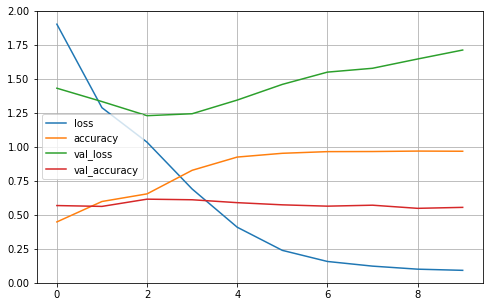

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1.5]
plt.savefig("figures/learning_curves_model_2", tight_layout=False)
plt.show()

In [ ]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [ ]:
results_df2 = history_df.iloc[-1:].copy()
results_df2.insert(0,'model','Simple RNN (64 units)') # want the model name to appear first
results_df2['test_accuracy'] = test_accuracy
results_df2['test_loss'] = test_loss
results_df2['training time (sec)'] = train_time      
results_df2['testing time (sec)'] = test_time      
results_df2

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,Simple RNN (64 units),0.091719,0.96801,1.71276,0.555062,0.563175,1.656414,157.793176,2.184164


## 2.2 RNN w/100 memory cells

In [ ]:
model_2a = Sequential()
model_2a.add(Embedding(input_dim = voc_size, output_dim = 128, input_length = 193))
model_2a.add(SimpleRNN(units = 100))
model_2a.add(Dense(units = 21, activation='softmax'))

model_2a.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 193, 128)          1280000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100)               22900     
_________________________________________________________________
dense_2 (Dense)              (None, 21)                2121      
Total params: 1,305,021
Trainable params: 1,305,021
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2a.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 2.2.a Model Training

In [ ]:
train_rt = TrainRuntimeCallback()
history = model_2a.fit(train_data_sm_rnn,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
#                   validation_data=(val_data_sm_rnn, one_hot_val_labels_sm))
                    validation_split = 0.15)   # comment out if setting validation_data value.

# Saving models locally after fitting
save_dir = "results/"
model_name = 'Reuters_2a.h5'
model_path = os.path.join(save_dir, model_name)
model_2a.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 21s 3ms/sample - loss: 1.7993 - accuracy: 0.4250 - val_loss: 1.7151 - val_accuracy: 0.4272
Epoch 2/10
6377/6377 [==============================] - 19s 3ms/sample - loss: 1.5809 - accuracy: 0.4980 - val_loss: 1.4877 - val_accuracy: 0.5133
Epoch 3/10
6377/6377 [==============================] - 19s 3ms/sample - loss: 1.3530 - accuracy: 0.5697 - val_loss: 1.4574 - val_accuracy: 0.5107
Epoch 4/10
6377/6377 [==============================] - 19s 3ms/sample - loss: 1.0559 - accuracy: 0.6583 - val_loss: 1.4366 - val_accuracy: 0.5497
Epoch 5/10
6377/6377 [==============================] - 19s 3ms/sample - loss: 0.6624 - accuracy: 0.8103 - val_loss: 1.3289 - val_accuracy: 0.5897
Epoch 6/10
6377/6377 [==============================] - 19s 3ms/sample - loss: 0.3878 - accuracy: 0.9050 - val_loss: 1.3876 - val_accuracy: 0.6039
Epoch 7/10
6377/6377 [==============================] - 19s 3ms/sample

In [ ]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

190.915457

In [ ]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.9647169709205627, val_acc: 0.6083481311798096


### 2.2.b Model Testing

In [ ]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_2a.evaluate(test_data_sm_rnn, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.602051854133606, test_loss=1.6644209677405801


In [ ]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

2.809977

### 2.2.c Model Performance

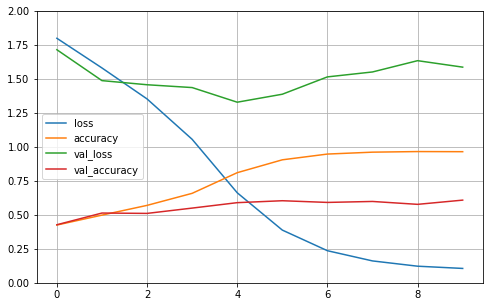

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_2a", tight_layout=False)
plt.show()

In [ ]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [ ]:
results_df2a = history_df.iloc[-1:].copy()
results_df2a.insert(0,'model','Simple RNN (100 units)') # want the model name to appear first
results_df2a['test_accuracy'] = test_accuracy
results_df2a['test_loss'] = test_loss
results_df2a['training time (sec)'] = train_time      
results_df2a['testing time (sec)'] = test_time     
results_df2a

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,Simple RNN (100 units),0.10573,0.964717,1.586867,0.608348,0.602052,1.664421,190.915457,2.809977


In [ ]:
results_df2=results_df2.append(results_df2a,ignore_index=True)
results_df2

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
0,Simple RNN (64 units),0.091719,0.968010,1.712760,0.555062,0.563175,1.656414,157.793176,2.184164
1,Simple RNN (100 units),0.105730,0.964717,1.586867,0.608348,0.602052,1.664421,190.915457,2.809977


In [ ]:
results_df2.to_pickle("results2.pkl") 

# 3. Experiment 3: LSTM RNN

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## 3.1 LSTM RNN

In [ ]:
model_3 = Sequential()
model_3.add(Embedding(input_dim = voc_size, output_dim = 64, input_length = 193))
model_3.add(LSTM(units = 32))
model_3.add(Dense(units = 21, activation='softmax'))

model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 193, 64)           640000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 21)                693       
Total params: 653,109
Trainable params: 653,109
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 3.1.a Model Training

In [ ]:
train_rt = TrainRuntimeCallback()
history = model_3.fit(train_data_sm_rnn,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
#                   validation_data=(val_data_sm_rnn, one_hot_val_labels_sm))
                    validation_split = 0.15)   # comment out if setting validation_data value.

# Saving models locally after fitting
save_dir = "results/"
model_name = 'Reuters_3.h5'
model_path = os.path.join(save_dir, model_name)
model_3.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 35s 5ms/sample - loss: 2.2593 - accuracy: 0.4261 - val_loss: 1.5748 - val_accuracy: 0.5258
Epoch 2/10
6377/6377 [==============================] - 29s 5ms/sample - loss: 1.3380 - accuracy: 0.5819 - val_loss: 1.2451 - val_accuracy: 0.5986
Epoch 3/10
6377/6377 [==============================] - 29s 4ms/sample - loss: 1.0819 - accuracy: 0.6556 - val_loss: 1.0240 - val_accuracy: 0.6625
Epoch 4/10
6377/6377 [==============================] - 30s 5ms/sample - loss: 0.9727 - accuracy: 0.6868 - val_loss: 1.0845 - val_accuracy: 0.6723
Epoch 5/10
6377/6377 [==============================] - 30s 5ms/sample - loss: 0.9855 - accuracy: 0.6760 - val_loss: 1.0138 - val_accuracy: 0.6528
Epoch 6/10
6377/6377 [==============================] - 29s 5ms/sample - loss: 0.8709 - accuracy: 0.7157 - val_loss: 0.9373 - val_accuracy: 0.7069
Epoch 7/10
6377/6377 [==============================] - 29s 5ms/sample

In [ ]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

295.388199

In [ ]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.8212325572967529, val_acc: 0.7397868633270264


### 3.1.b Model Testing

In [ ]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_3.evaluate(test_data_sm_rnn, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.7559395432472229, test_loss=0.8839631919984426


In [ ]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

4.710983

### 3.1.c Model Performance

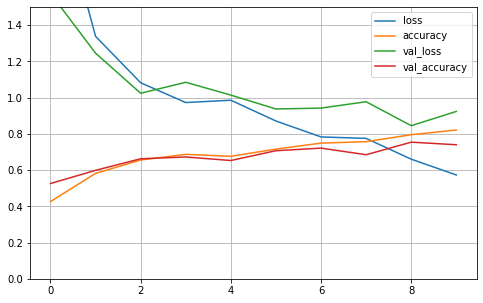

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_3", tight_layout=False)
plt.show()

In [ ]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [ ]:
results_df3 = history_df.iloc[-1:].copy()
results_df3.insert(0,'model','LSTM RNN baseline') # want the model name to appear first
results_df3['test_accuracy'] = test_accuracy
results_df3['test_loss'] = test_loss
results_df3['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df3['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df3

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,LSTM RNN baseline,0.572972,0.821233,0.923595,0.739787,0.75594,0.883963,295.388199,4.710983


## 3.2 LSTM RNN w/100 memory cell units

In [ ]:
model_3a = Sequential()
model_3a.add(Embedding(input_dim = voc_size, output_dim = 64, input_length = 193))
model_3a.add(LSTM(units = 100))
model_3a.add(Dense(units = 21, activation='softmax'))


model_3a.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 193, 64)           640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_1 (Dense)              (None, 21)                2121      
Total params: 708,121
Trainable params: 708,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_3a.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 3.2.a Model Training

In [ ]:
train_rt = TrainRuntimeCallback()
history = model_3a.fit(train_data_sm_rnn,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
#                   validation_data=(val_data_sm_rnn, one_hot_val_labels_sm))
                    validation_split = 0.15)   # comment out if setting validation_data value.

# Saving models locally after fitting
save_dir = "results/"
model_name = 'Reuters_3a.h5'
model_path = os.path.join(save_dir, model_name)
model_3a.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 60s 9ms/sample - loss: 1.9634 - accuracy: 0.4171 - val_loss: 1.6822 - val_accuracy: 0.4103
Epoch 2/10
6377/6377 [==============================] - 53s 8ms/sample - loss: 1.4470 - accuracy: 0.5349 - val_loss: 1.2863 - val_accuracy: 0.5897
Epoch 3/10
6377/6377 [==============================] - 56s 9ms/sample - loss: 1.2110 - accuracy: 0.6080 - val_loss: 1.2482 - val_accuracy: 0.6075
Epoch 4/10
6377/6377 [==============================] - 52s 8ms/sample - loss: 1.0396 - accuracy: 0.6643 - val_loss: 1.1520 - val_accuracy: 0.6190
Epoch 5/10
6377/6377 [==============================] - 53s 8ms/sample - loss: 0.9119 - accuracy: 0.6966 - val_loss: 0.9182 - val_accuracy: 0.7016
Epoch 6/10
6377/6377 [==============================] - 49s 8ms/sample - loss: 0.7769 - accuracy: 0.7485 - val_loss: 0.9060 - val_accuracy: 0.7087
Epoch 7/10
6377/6377 [==============================] - 49s 8ms/sample

In [ ]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

525.963719

In [ ]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.8778422474861145, val_acc: 0.7539964318275452


### 3.2.b Model Testing

In [ ]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_3a.evaluate(test_data_sm_rnn, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.7607991099357605, test_loss=0.901094690512375


In [ ]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

9.774533

### 3.2.c Model Performance

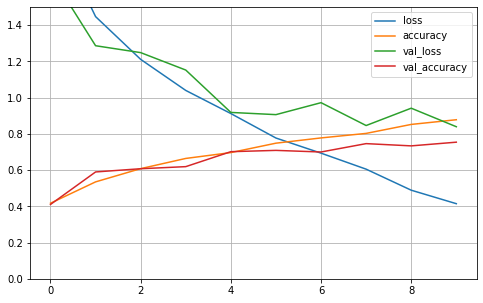

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_3a", tight_layout=False)
plt.show()

In [ ]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [ ]:
results_df3a = history_df.iloc[-1:].copy()
results_df3a.insert(0,'model','LSTM RNN (100 memory cell units)') # want the model name to appear first
results_df3a['test_accuracy'] = test_accuracy
results_df3a['test_loss'] = test_loss
results_df3a['training time (sec)'] = train_time      
results_df3a['testing time (sec)'] = test_time      
results_df3a

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,LSTM RNN (100 memory cell units),0.414566,0.877842,0.839277,0.753996,0.760799,0.901095,525.963719,9.774533


## 3.3 LSTM RNN w/10% dropout

In [ ]:
model_3b = Sequential()
model_3b.add(Embedding(input_dim = voc_size, output_dim = 64, input_length = 193))
# model_3b.add(layers.SpatialDropout1D(0.2))
model_3b.add(LSTM(units=100))
model_3b.add(layers.Dropout(0.1))
model_3b.add(Dense(units = 21, activation='softmax'))

model_3b.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 193, 64)           640000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 21)                2121      
Total params: 708,121
Trainable params: 708,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_3b.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 3.3.a Model Training

In [ ]:
train_rt = TrainRuntimeCallback()
history = model_3b.fit(train_data_sm_rnn,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
#                   validation_data=(val_data_sm_rnn, one_hot_val_labels_sm))
                    validation_split = 0.15)   # comment out if setting validation_data value.

# Saving models locally after fitting
save_dir = "results/"
model_name = 'Reuters_3b.h5'
model_path = os.path.join(save_dir, model_name)
model_3b.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 56s 9ms/sample - loss: 1.9882 - accuracy: 0.4068 - val_loss: 1.6553 - val_accuracy: 0.4103
Epoch 2/10
6377/6377 [==============================] - 49s 8ms/sample - loss: 1.3877 - accuracy: 0.5559 - val_loss: 1.2533 - val_accuracy: 0.5933
Epoch 3/10
6377/6377 [==============================] - 49s 8ms/sample - loss: 1.1423 - accuracy: 0.6189 - val_loss: 1.0364 - val_accuracy: 0.6492
Epoch 4/10
6377/6377 [==============================] - 50s 8ms/sample - loss: 0.9353 - accuracy: 0.6771 - val_loss: 0.9503 - val_accuracy: 0.6812
Epoch 5/10
6377/6377 [==============================] - 49s 8ms/sample - loss: 0.8510 - accuracy: 0.7082 - val_loss: 0.8999 - val_accuracy: 0.7123
Epoch 6/10
6377/6377 [==============================] - 49s 8ms/sample - loss: 0.8167 - accuracy: 0.7220 - val_loss: 0.9184 - val_accuracy: 0.7043
Epoch 7/10
6377/6377 [==============================] - 49s 8ms/sample

In [ ]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

504.947276

In [ ]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.8546338677406311, val_acc: 0.7779751420021057


### 3.3.b Model Testing

In [ ]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_3b.evaluate(test_data_sm_rnn, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.7613390684127808, test_loss=0.8686605364921026


In [ ]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

8.89068

### 3.3.c Model Performance

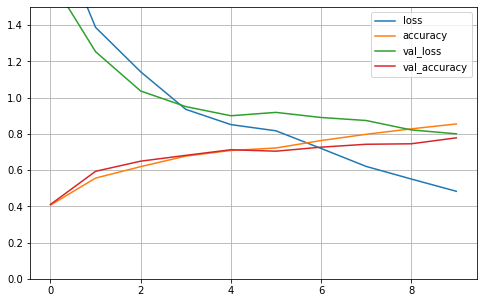

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_3b", tight_layout=False)
plt.show()

In [ ]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [ ]:
results_df3b = history_df.iloc[-1:].copy()
results_df3b.insert(0,'model','LSTM RNN with Drop') # want the model name to appear first
results_df3b['test_accuracy'] = test_accuracy
results_df3b['test_loss'] = test_loss
results_df3b['training time (sec)'] = train_time      
results_df3b['testing time (sec)'] = test_time     
results_df3b

,model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,training time (sec),testing time (sec)
9,LSTM RNN with Drop,0.482945,0.854634,0.800173,0.777975,0.868661,0.761339,504.947276,8.89068


## 3.4 Variational RNN

In [ ]:
model_3c = Sequential()
model_3c.add(Embedding(input_dim = voc_size, output_dim = 64, input_length = 193))
# model_3c.add(layers.SpatialDropout1D(0.2))
model_3c.add(LSTM(units = 100, dropout=0.2, recurrent_dropout=0.2))
model_3c.add(Dense(units = 21, activation='softmax'))

model_3c.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 193, 64)           640000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_3 (Dense)              (None, 21)                2121      
Total params: 708,121
Trainable params: 708,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_3c.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 3.4.a Model Training

In [ ]:
train_rt = TrainRuntimeCallback()
history = model_3c.fit(train_data_sm_rnn,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
#                   validation_data=(val_data_sm_rnn, one_hot_val_labels_sm))
                    validation_split = 0.15)   # comment out if setting validation_data value.

# Saving models locally after fitting
save_dir = "results/"
model_name = 'Reuters_3c.h5'
model_path = os.path.join(save_dir, model_name)
model_3c.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 60s 9ms/sample - loss: 1.9490 - accuracy: 0.4112 - val_loss: 1.6870 - val_accuracy: 0.4103
Epoch 2/10
6377/6377 [==============================] - 52s 8ms/sample - loss: 1.5230 - accuracy: 0.4999 - val_loss: 1.3167 - val_accuracy: 0.5799
Epoch 3/10
6377/6377 [==============================] - 52s 8ms/sample - loss: 1.2850 - accuracy: 0.5871 - val_loss: 1.2110 - val_accuracy: 0.6048
Epoch 4/10
6377/6377 [==============================] - 54s 9ms/sample - loss: 1.1123 - accuracy: 0.6348 - val_loss: 1.0976 - val_accuracy: 0.6190
Epoch 5/10
6377/6377 [==============================] - 53s 8ms/sample - loss: 0.9631 - accuracy: 0.6712 - val_loss: 0.9842 - val_accuracy: 0.6758
Epoch 6/10
6377/6377 [==============================] - 55s 9ms/sample - loss: 0.8484 - accuracy: 0.7157 - val_loss: 0.9661 - val_accuracy: 0.7025
Epoch 7/10
6377/6377 [==============================] - 55s 9ms/sample

In [ ]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

554.97682

In [ ]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.8249960541725159, val_acc: 0.74866783618927


### 3.4.b Model Testing

In [ ]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_3c.evaluate(test_data_sm_rnn, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.7489200830459595, test_loss=0.903414309411018


In [ ]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

9.567821

### 3.4.c Model Performance

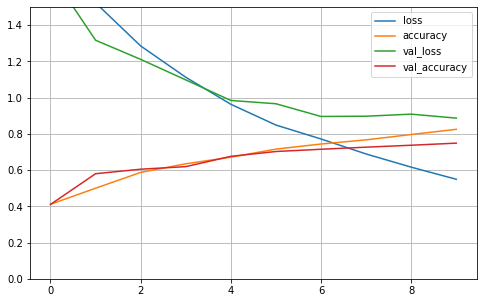

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_3c", tight_layout=False)
plt.show()

In [ ]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [ ]:
results_df3c = history_df.iloc[-1:].copy()
results_df3c.insert(0,'model','Variational RNN with Drop/Recurrent Drop') # want the model name to appear first
results_df3c['test_accuracy'] = test_accuracy
results_df3c['test_loss'] = test_loss
results_df3c['training time (sec)'] = train_time      
results_df3c['testing time (sec)'] = test_time     
results_df3c

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,Variational RNN with Drop/Recurrent Drop,0.549221,0.824996,0.886675,0.748668,0.74892,0.903414,554.97682,9.567821


In [ ]:
results_df3=results_df3.append(results_df3a,ignore_index=True)
results_df3=results_df3.append(results_df3b,ignore_index=True)
results_df3=results_df3.append(results_df3c,ignore_index=True)
results_df3

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
0,LSTM RNN baseline,0.572972,0.821233,0.923595,0.739787,0.755940,0.883963,295.388199,4.710983
1,LSTM RNN (100 memory cell units),0.414566,0.877842,0.839277,0.753996,0.760799,0.901095,525.963719,9.774533
2,LSTM RNN with Drop,0.482945,0.854634,0.800173,0.777975,0.761339,0.868661,504.947276,8.890680
3,Variational RNN with Drop/Recurrent Drop,0.549221,0.824996,0.886675,0.748668,0.748920,0.903414,554.976820,9.567821


In [ ]:
results_df3.to_pickle("results3.pkl") 

# 4. Experiment 4: CNN

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## 4.1 1D CNN

In [ ]:
model_4 = Sequential()
model_4.add(Embedding(input_dim = voc_size, output_dim = 64, input_length=193))
model_4.add(Conv1D(filters = 32, kernel_size = 3, activation='relu')) 
model_4.add(Flatten())
model_4.add(Dense(units = 512, activation='relu')) 
# model_4.add(layers.Dropout(0.5)) 
model_4.add(Dense(units = 21, activation='softmax'))

model_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 193, 64)           640000    
_________________________________________________________________
conv1d (Conv1D)              (None, 191, 32)           6176      
_________________________________________________________________
flatten (Flatten)            (None, 6112)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3129856   
_________________________________________________________________
dense_1 (Dense)              (None, 21)                10773     
Total params: 3,786,805
Trainable params: 3,786,805
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 4.1.a Model Training

In [ ]:
train_rt = TrainRuntimeCallback()
history = model_4.fit(train_data_sm_rnn, one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
                    validation_split=0.15)

# Saving models locally after fitting
save_dir = "results/"
model_name = 'Reuters_4.h5'
model_path = os.path.join(save_dir, model_name)
model_4.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 7s 1ms/sample - loss: 1.3833 - accuracy: 0.5499 - val_loss: 0.9843 - val_accuracy: 0.6767
Epoch 2/10
6377/6377 [==============================] - 7s 1ms/sample - loss: 0.7232 - accuracy: 0.7913 - val_loss: 0.7030 - val_accuracy: 0.7975
Epoch 3/10
6377/6377 [==============================] - 7s 1ms/sample - loss: 0.3649 - accuracy: 0.9014 - val_loss: 0.6743 - val_accuracy: 0.8215
Epoch 4/10
6377/6377 [==============================] - 7s 1ms/sample - loss: 0.2002 - accuracy: 0.9541 - val_loss: 0.6686 - val_accuracy: 0.8419
Epoch 5/10
6377/6377 [==============================] - 7s 1ms/sample - loss: 0.1423 - accuracy: 0.9644 - val_loss: 0.7968 - val_accuracy: 0.8064
Epoch 6/10
6377/6377 [==============================] - 7s 1ms/sample - loss: 0.1273 - accuracy: 0.9644 - val_loss: 0.7094 - val_accuracy: 0.8384
Epoch 7/10
6377/6377 [==============================] - 6s 963us/sample - lo

In [ ]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

67.70069

In [ ]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.967069149017334, val_acc: 0.8206039071083069


### 4.1.b Model Testing

In [ ]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_4.evaluate(test_data_sm_rnn, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.8245140314102173, test_loss=0.8112107136852026


In [ ]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.411464

### 4.1.c Model Performance

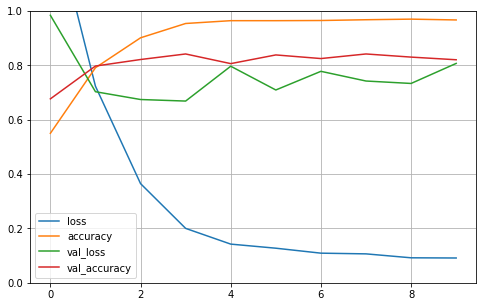

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_4", tight_layout=False)
plt.show()

In [ ]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [ ]:
results_df4 = history_df.iloc[-1:].copy()
results_df4.insert(0,'model','1D CNN baseline') # want the model name to appear first
results_df4['test_accuracy'] = test_accuracy
results_df4['test_loss'] = test_loss
results_df4['training time (sec)'] = train_time      
results_df4['testing time (sec)'] = test_time      
results_df4

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,1D CNN baseline,0.091262,0.967069,0.807187,0.820604,0.824514,0.811211,67.70069,0.411464


## 4.2 1D CNN w/50% dropout

In [ ]:
model_4a = Sequential()
model_4a.add(Embedding(input_dim = voc_size, output_dim = 64, input_length=193))
model_4a.add(Conv1D(filters = 32, kernel_size = 3, activation='relu')) 
model_4a.add(Flatten())
model_4a.add(Dense(units = 512, activation='relu')) 
model_4a.add(layers.Dropout(0.5)) 
model_4a.add(Dense(units = 21, activation='softmax'))

model_4a.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 193, 64)           640000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 191, 32)           6176      
_________________________________________________________________
flatten_1 (Flatten)          (None, 6112)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               3129856   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 21)                10773     
Total params: 3,786,805
Trainable params: 3,786,805
Non-trainable params: 0
____________________________________________

In [ ]:
model_4a.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 4.2.a Model Training

In [ ]:
train_rt = TrainRuntimeCallback()
history = model_4a.fit(train_data_sm_rnn, one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
                    validation_split=0.15)

# Saving models locally after fitting
save_dir = "results/"
model_name = 'Reuters_4a.h5'
model_path = os.path.join(save_dir, model_name)
model_4a.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 9s 1ms/sample - loss: 1.4508 - accuracy: 0.5302 - val_loss: 1.0132 - val_accuracy: 0.6563
Epoch 2/10
6377/6377 [==============================] - 6s 993us/sample - loss: 0.8350 - accuracy: 0.7433 - val_loss: 0.7676 - val_accuracy: 0.7629
Epoch 3/10
6377/6377 [==============================] - 6s 1ms/sample - loss: 0.5047 - accuracy: 0.8587 - val_loss: 0.6110 - val_accuracy: 0.8437
Epoch 4/10
6377/6377 [==============================] - 7s 1ms/sample - loss: 0.2968 - accuracy: 0.9233 - val_loss: 0.6226 - val_accuracy: 0.8375
Epoch 5/10
6377/6377 [==============================] - 7s 1ms/sample - loss: 0.1934 - accuracy: 0.9517 - val_loss: 0.6738 - val_accuracy: 0.8464
Epoch 6/10
6377/6377 [==============================] - 6s 1ms/sample - loss: 0.1410 - accuracy: 0.9600 - val_loss: 0.7066 - val_accuracy: 0.8419
Epoch 7/10
6377/6377 [==============================] - 7s 1ms/sample - lo

In [ ]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

81.807369

In [ ]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.9695781469345093, val_acc: 0.8410301804542542


### 4.2.b Model Testing

In [ ]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_4a.evaluate(test_data_sm_rnn, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.8331533670425415, test_loss=0.792520973903829


In [ ]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.403489

### 4.2.c Model Performance

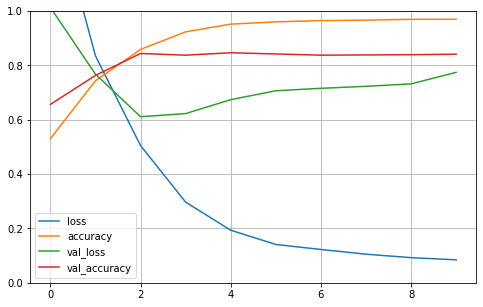

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_4a", tight_layout=False)
plt.show()

In [ ]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [ ]:
results_df4a = history_df.iloc[-1:].copy()
results_df4a.insert(0,'model','1D CNN baseline with Drop') # want the model name to appear first
results_df4a['test_accuracy'] = test_accuracy
results_df4a['test_loss'] = test_loss
results_df4a['training time (sec)'] = train_time      
results_df4a['testing time (sec)'] = test_time      
results_df4a

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,1D CNN baseline with Drop,0.084531,0.969578,0.774338,0.84103,0.833153,0.792521,81.807369,0.403489


## 4.3 1D CNN w/50% dropout and max pooling

In [ ]:
model_4b = Sequential()
model_4b.add(Embedding(input_dim = voc_size, output_dim = 64, input_length=193))
model_4b.add(Conv1D(filters = 32, kernel_size = 3, activation='relu')) 
model_4b.add(MaxPooling1D())
model_4b.add(layers.Dropout(0.5))
model_4b.add(Flatten())
model_4b.add(Dense(units = 512, activation='relu')) 
model_4b.add(Dense(units = 21, activation='softmax'))

model_4b.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 193, 64)           640000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 191, 32)           6176      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 95, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 95, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3040)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1556992   
_________________________________________________________________
dense_5 (Dense)              (None, 21)               

In [ ]:
model_4b.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 4.3.a Model Training

In [ ]:
train_rt = TrainRuntimeCallback()
history = model_4b.fit(train_data_sm_rnn, one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
                    validation_split=0.15)

# Saving models locally after fitting
save_dir = "results/"
model_name = 'Reuters_4b.h5'
model_path = os.path.join(save_dir, model_name)
model_4b.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 9s 1ms/sample - loss: 1.4660 - accuracy: 0.5242 - val_loss: 1.1159 - val_accuracy: 0.6448
Epoch 2/10
6377/6377 [==============================] - 7s 1ms/sample - loss: 0.8807 - accuracy: 0.7163 - val_loss: 0.8078 - val_accuracy: 0.7487
Epoch 3/10
6377/6377 [==============================] - 7s 1ms/sample - loss: 0.5556 - accuracy: 0.8429 - val_loss: 0.6856 - val_accuracy: 0.8028
Epoch 4/10
6377/6377 [==============================] - 7s 1ms/sample - loss: 0.3341 - accuracy: 0.9108 - val_loss: 0.6395 - val_accuracy: 0.8313
Epoch 5/10
6377/6377 [==============================] - 7s 1ms/sample - loss: 0.2226 - accuracy: 0.9432 - val_loss: 0.7224 - val_accuracy: 0.8339
Epoch 6/10
6377/6377 [==============================] - 7s 1ms/sample - loss: 0.1736 - accuracy: 0.9553 - val_loss: 0.6997 - val_accuracy: 0.8348
Epoch 7/10
6377/6377 [==============================] - 7s 1ms/sample - loss

In [ ]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

69.460854

In [ ]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.9651873707771301, val_acc: 0.8232682347297668


### 4.3.b Model Testing

In [ ]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model_4b.evaluate(test_data_sm_rnn, one_hot_test_labels_sm, callbacks=[test_rt], verbose=0)
print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

test_accuracy=0.8282937407493591, test_loss=0.8243980428312561


In [ ]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.443525

### 4.3.c Model Performance

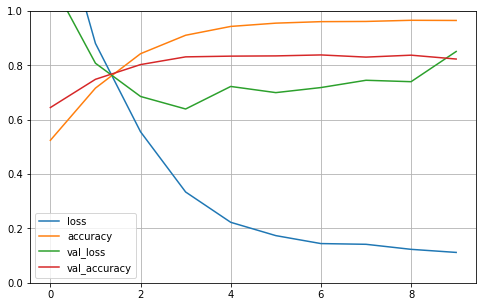

In [ ]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_4b", tight_layout=False)
plt.show()

In [ ]:
history_dict = history.history.copy()
# history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)

In [ ]:
results_df4b = history_df.iloc[-1:].copy()
results_df4b.insert(0,'model','1D CNN with Drop and max pooling') # want the model name to appear first
results_df4b['test_accuracy'] = test_accuracy
results_df4b['test_loss'] = test_loss
results_df4b['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df4b['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df4b

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
9,1D CNN with Drop and max pooling,0.111764,0.965187,0.851045,0.823268,0.828294,0.824398,69.460854,0.443525


## 5. Summary of Experiment Results


In [ ]:
results_df4=results_df4.append(results_df4a,ignore_index=True)
results_df4=results_df4.append(results_df4b,ignore_index=True)
results_df4

,model,loss,accuracy,val_loss,val_accuracy,test_accuracy,test_loss,training time (sec),testing time (sec)
0,1D CNN baseline,0.091262,0.967069,0.807187,0.820604,0.824514,0.811211,67.700690,0.411464
1,1D CNN baseline with Drop,0.084531,0.969578,0.774338,0.841030,0.833153,0.792521,81.807369,0.403489
2,1D CNN with Drop and max pooling,0.111764,0.965187,0.851045,0.823268,0.828294,0.824398,69.460854,0.443525


In [ ]:
results_df4.to_pickle("results4.pkl") 

In [ ]:
frames = [results_df, results_df2, results_df3, results_df4]

df_final = pd.concat(frames, keys=['Exp 1','Exp 2','Exp 3', 'Exp 4'])

df_final

model      loss  accuracy  \
Exp 1 0                   DNN (2 layers) 9 topics  0.094744  0.965501   
      1                    DNN (2 layers 256/256)  0.066245  0.967853   
      2                     DNN (2 layers) w Drop  0.095098  0.966756   
      3              DNN (2 layers) w Drop and L1  1.019556  0.877685   
      4                    DNN (2 layers) w Embed  0.071710  0.966912   
      5          DNN (2 layers) w Embed + Dropout  0.079839  0.968637   
Exp 2 0                     Simple RNN (64 units)  0.091719  0.968010   
      1                    Simple RNN (100 units)  0.105730  0.964717   
Exp 3 0                         LSTM RNN baseline  0.572972  0.821233   
      1          LSTM RNN (100 memory cell units)  0.414566  0.877842   
      2                        LSTM RNN with Drop  0.482945  0.854634   
      3  Variational RNN with Drop/Recurrent Drop  0.549221  0.824996   
Exp 4 0                           1D CNN baseline  0.091262  0.967069   
      1                 1D CNN baseline with Drop  0.084531  0.969578   
      2          1D CNN with Drop and max pooling  0.111764  0.965187   

         val_loss  val_accuracy  test_accuracy  test_loss  \
Exp 1 0  0.683556      0.863233       0.860151   0.678582   
      1  0.732996      0.865897       0.859071   0.755467   
      2  0.691740      0.863233       0.857451   0.703502   
      3  1.067072      0.860568       0.854212   1.084547   
      4  0.834077      0.805506       0.811555   0.825477   
      5  0.841354      0.816163       0.819114   0.854932   
Exp 2 0  1.712760      0.555062       0.563175   1.656414   
      1  1.586867      0.608348       0.602052   1.664421   
Exp 3 0  0.923595      0.739787       0.755940   0.883963   
      1  0.839277      0.753996       0.760799   0.901095   
      2  0.800173      0.777975       0.761339   0.868661   
      3  0.886675      0.748668       0.748920   0.903414   
Exp 4 0  0.807187      0.820604       0.824514   0.811211   
      1  0.774338      0.841030       0.833153   0.792521   
      2  0.851045      0.823268       0.828294   0.824398   

         training time (sec)  testing time (sec)  
Exp 1 0            14.734655            0.241027  
      1            39.019436            0.288834  
      2            15.595836            0.186922  
      3            21.216728            0.246425  
      4            56.138766            0.217395  
      5            55.968919            0.217657  
Exp 2 0           157.793176            2.184164  
      1           190.915457            2.809977  
Exp 3 0           295.388199            4.710983  
      1           525.963719            9.774533  
      2           504.947276            8.890680  
      3           554.976820            9.567821  
Exp 4 0            67.700690            0.411464  
      1            81.807369            0.403489  
      2            69.460854            0.443525